In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Download dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


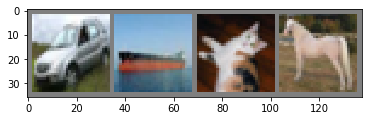

  car  ship   cat horse


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Train classical network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [0]:
net = Net()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.247
[1,  4000] loss: 1.894
[1,  6000] loss: 1.700
[1,  8000] loss: 1.573
[1, 10000] loss: 1.550
[1, 12000] loss: 1.478
Finished Training


In [0]:
#Whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [0]:
#Per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 68 %
Accuracy of  bird : 27 %
Accuracy of   cat : 15 %
Accuracy of  deer : 26 %
Accuracy of   dog : 44 %
Accuracy of  frog : 54 %
Accuracy of horse : 61 %
Accuracy of  ship : 69 %
Accuracy of truck : 60 %


# PGD implementation

In [0]:
def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, eps,
                               clamp=(0,1)):
    x_adv = x
    num_channels = x.shape[1]

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
        loss = loss_fn(prediction, y)
        loss.backward()

        # Gradient step
        gradients = _x_adv.grad.sign() * step_size #step norm
        
        # Project back into l_norm ball and correct range
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps) #eps norm

        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

# Train adversial network

In [54]:
net = Net()
net.train()
optimiser = optim.SGD(net.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1):
    for x, y, in trainloader:
        x_adv = projected_gradient_descent(net, x, y, loss_fn, 
                                           num_steps=40, step_size=0.01,
                                           eps=0.3)
        optimiser.zero_grad()
        y_pred = net(x_adv)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimiser.step()
    print(epoch)

AttributeError: ignored

In [7]:
#Whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network with PGD on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 30 %
